# 1. Face Generation using GAN

Title says it all! Yup we will going to generate synthetic human faces using a generative adversarial network. We have a detailed discussion about the GAN in chapter 2. Now we will see its one of the most interesting application in synthetic face generation. We will going to develop a model which will be trained on celebrity face data set hosted by Kaggle. Once the model got trained, it should generate look alike faces.

We will learn about following things:

- What is face generation?
- How to get the data set and pre-process it.
- Create a generative adversarial network and train it.
- Generate new faces using the trained GAN model.

As this is case-study, we will not dive into the conceptual part much as we have already covered it in past chapter. So without wasting our time, let's dive into the problem.

# 2. What is Face Generation?

Face generation is nothing but generation of synthetic faces using artificial intelligence. It is similar to the data generation using GAN or VAE. For creating a face generator you can create a GAN or VAE and train it thousands of face images. After convergence our network (Decoder in case of VAE and Generator in case of GAN) is ready to generate new faces. We can control the shapes, colors, gender, accessories etc by tuning of latent variables. 

I don't know whether you heard off a mobile application FaceApp; If you don't know, let me give you a brief explanation about the application. FaceApp captures face images using smart phone camera and then send it to a remote server where it generates pretty cool effects on your picture using deep learning networks (specifically Style-GAN). You can select an old age filter where it can generate an image with older age features of the person. Similarly it can generate younger age features for the same picture. It can make you smile or grow a beard on your face. It can even generate Female/Male you. Following is an example.

<img src='1_FaceApp.png' width=400>

*image source: www.faceapp.com*

Cool! Yup I agree. But what this app is doing internally? This app is using face generation with a generative adversarial neural network. But how can a network generate these kind of variations? well if you remember the concepts from data generation using variational autoencoder, you can get this clearly! By controlling latent space variables we can control different styles of the generated data. Same principle applies here too. Following is the example which we had discussed in previous chapter.

<img src='2_zero_image.png' width=400>

Now here is he question: Can we generate real looking faces with the help of neural networks? Answer is Hell Yes! We can generate the faces using GAN. Thats what we will do in this project.

We will going to train a very simple GAN architecture to generate faces by training it with a Kaggle dataset. Are you interested? Hell Yes! here take my money and teach me!

# 3. GAN for Face Generation

So as we have discussed concepts of GAN already; We will jump into over application directly (Oh it rhymes already, directly). To implement this following are the ingredients of the recipe:

- Dataset (obviously!)
- Data Pre-processor
- Generator
- Discriminator
- GAN

So without wasting anytime let's start with the implementation.

## 3.1 Data set

We will use Kaggle's Large Scale CelebFace dataset (CelebA) for training our GAN. You can get description about this data set from [here](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).This dataset was developed and published by Ziwei Liu, et al. for their 2015 paper titled ["From Facial Parts Responses to Face Detection: A Deep Learning Approach](https://arxiv.org/abs/1509.06451)." Kaggle provides one click download link of the required data set [here](https://www.kaggle.com/jessicali9530/celeba-dataset). 

This data set will take about 1 GB of disk space after downloading. It will be a zip file, which you will need to extract. This data is a labeled data set designed for supervised analysis tasks; so after extraction you will find some csv files for different analysis purposes. We are more interested in image data set. It will be again a compressed zip file of about 1.4 GB. after extracting images out of it, you will get around 200,000 images of size 178 X 218 pixels.

Following are some sample images from the dataset.

<img src='3_Dataset_Faces.png' width=800>

Great! we got the dataset. Now as you can see there are lot of ambient space other than faces in these images. This is redundant data to be generated. So we will crop only the face region from these images. We will use a pretrained face detector network to do this job for us.

## 3.2 Data Pre-Processor

We will use [MTCNN](https://github.com/ipazc/mtcnn) Face detection library to extract faces from the images. It is basically a pre trained CNN which could be downloaded as a Python package from command line argument:

        Python -m pip install mtcnn

Once downloaded we are ready to use this library to extract only face regions from the images. After execution the detector returns a list of JSON objects. Each JSON object contains three main keys: 'box', 'confidence' and 'keypoints':

- The bounding box is formatted as [x, y, width, height] under the key 'box'.
- The confidence is the probability for a bounding box to be matching a face.
- The keypoints are formatted into a JSON object with the keys 'left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right'. Each keypoint is identified by a pixel position (x, y).

We are only interested in face region which we will get from 'box' information. We will resize the face image to lower dimensions (80 X 80) to train the GAN on small GPUs. To do this we will write some functions to load and the data set and use MTCNN for face extraction. Following lines will do this for us.

In [11]:
import os
from PIL import Image # For Image read/write
from mtcnn.mtcnn import MTCNN # For face extraction
import numpy as np

# load an image as an rgb numpy array
def load_image(filename):
    
    # load image from file
    image = Image.open(filename)
    
    # convert to RGB, if needed
    image = image.convert('RGB')
    
    # convert to array
    pixels = np.array(image)
    return pixels

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    faces = list()
    model = MTCNN()
    
    # enumerate files
    for filename in os.listdir(directory):
    
        # load the image
        pixels = load_image(directory + filename)
        face = extract_face(model, pixels)
        if face is None:
            continue
        
        # store
        faces.append(face)
        
        # stop once we have enough
        if len(faces) >= n_faces:
            break
    return np.array(faces)

# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
    
    # detect face in the image
    faces = model.detect_faces(pixels)
    
    # skip cases where we could not detect a face
    if len(faces) == 0:
        return None
    
    # extract details of the face
    x1, y1, width, height = faces[0]['box']
    
    # force detected pixel values to be positive (bug fix)
    x1, y1 = abs(x1), abs(y1)
    
    # convert into coordinates
    x2, y2 = x1 + width, y1 + height
    
    # retrieve face pixels
    face_pixels = pixels[y1:y2, x1:x2]
    
    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = np.array(image)
    return face_array

Nice! Now to plot the faces we will use following function 

In [12]:
import matplotlib.pyplot as plt

# plot a list of loaded faces
def plot_faces(faces, n):
    for i in range(n * n):
        
        # define subplot
        plt.subplot(n, n, 1 + i)
        
        # turn off axis
        plt.axis('off')
        
        # plot raw pixel data
        plt.imshow(faces[i])
    plt.show()

Let's see how this works. We will load 16 faces and arrange them in a 4X4 grid for visualization.

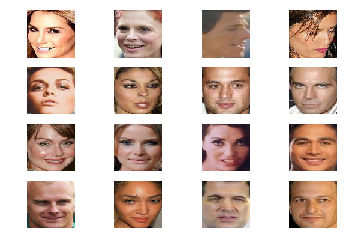

In [13]:
n_faces = 16

image = load_faces('E:/FaceDataset/celeba-dataset/img_align_celeba/',n_faces)
plot_faces(image,4)

Wow! it works like a charm. Now there are more than 200K images in the data set. To train a GAN on the dataset of this size, we would required a very high end GPU, which is difficult to arrange everyone. As our purpose for this case study is to demonstrate the capability of GAN, we will select only 50K images from the data set, and will train our GAN on this data set. To store the extracted dataset we will use numpy's savez_compressed function. Following lines will do this for us.

In [ ]:
n_faces = 50000
image = load_faces('E:/FaceDataset/celeba-dataset/img_align_celeba/',n_faces)
savez_compressed('img_align_celeba.npz', image)

Once we got the processed data set. Now we are ready to create generator and discriminator networks to be trained.

## 3.3. Generator

We will create a generator network with 4 Transposed convolution layers; 1 Dense layer to represent the latent space from where the generator will try to generate faces. We will apply leaky ReLU on the output of each layer. following will be the network architecture of generator. 

In [4]:
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dropout, Dense, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import pyplot
from numpy.random import randint
from numpy.random import randn

# define the standalone generator model
def get_generator(latent_dim):
    model = Sequential()
    
    # foundation for 5x5 feature maps
    n_nodes = 128 * 5 * 5
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))
    
    # upsample to 10x10
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 20x20
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 40x40
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 80x80
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # output layer 80x80x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

Using TensorFlow backend.


The generator model takes as input a point in the latent space and outputs a single 80Ã—80 color image.

So we will start with a 1D vector with the length of 128. It will be work as the input to the generator. We will generate it with the random data generator. Then we will reshape the vector into multiple small 2D patches of size 5X5 this information then will be processed through 4 transposed convolution layers. At each convolution we will use stride size of 2X2 which will upscale the input dimension with a factor of 2. We will do this upscaling with leaky relu for 4 times; this will give us an image of size 80X80X3 at the output. At the output layer, we will use hyper tangent (Tanh) as the activation function.

## 3.4. Discriminator

Now we are ready to create the discriminator. It will take an image of 80X80X3 at the input (same as the output dimensions of the generator) and predict whether the input image is a fake (outputs 0) one or the real (outputs 1). As the discriminator is a conventional convolution network; it will consist of similar kind of architecture.

We will use 5 convolutional layers in the architecture and all the layers will perform convolution with the stride size of 2 (Except the first layer). This will avoid the requirement of pooling layers in the network. Again we will use Leaky Relu at the output of each layer. We will use a flatten to reshape the data, a dropout layer to add some regularization to the network and a dense layer to predict the output of the network. Our network will be compiled with Adaptive momentum (ADAM) optimizer which will provide us adaptive learning rates. We will use binary cross entropy as the loss function as we are having only two classes here (Real or Fake).

Following function will create a discriminator for us

In [5]:
# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
    model = Sequential()
    
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample to 40x40
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample to 20x30
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample to 10x10
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample to 5x5
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Great! So we got the generator and discriminator both with us, and now we are ready to create a GAN by combining both the networks. Here we will train our discriminator model separately and generator model in separate. So we will train generator with output and loss generated by discriminator. While GAN being trained we will refrain the training of the discriminator weights. This will ensure us weight optimization for generator model only.

## 3.5 GAN

Let's create our GAN in following lines.

In [6]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    
    # make weights in the discriminator not trainable
    d_model.trainable = False
    
    # connect them
    model = Sequential()
    
    # add generator
    model.add(g_model)
    
    # add the discriminator
    model.add(d_model)
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

So we have complete GAN architecture with us now. our next task is training of this network. But before going into that, we need to rescale our input data. If you remember we has used hyper tangent as the activation in the output layer of the generator, which generates output in the range of -1 to 1. So we need to ensure that our input data for discriminator must follow the same range. To do this normalization, we will add following function to our code.

In [7]:
# load and prepare training images
def load_real_samples():
    
    # load the face dataset
    data = np.load('./img_align_celeba.npz')
    X = data['arr_0']
    
    # convert from unsigned ints to floats
    X = X.astype('float32')
    
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

Everything looks well as of now. Our next task is to prepare input data for our discriminator as well as for the generator. As we have unlabeled data with us. Our discriminator doesn't have a clue about real or fake data. For doing this we will create two input sources which will generate real and fake data to fool the discriminator. 

Real data generator will create batches of random images from the actual data set and label all the images as class 1. Then we will create the fake samples using the generator network. But for that we will need to provide some input data for generator too.

So in following snippet, we will add 3 functions for data generation:

- First function will generate batches of real dataset.
- Second function will create random Gaussian samples for input to the generator.
- And third function will generate fake samples using generator network.

Let's write it down.

In [8]:
# select real samples
def generate_real_samples(dataset, n_samples):
    
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    
    # retrieve selected images
    X = dataset[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # predict outputs
    X = g_model.predict(x_input)
    
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

Well it's time to check the list of ingredients. We have:

- Generator network
- Discriminator network
- GAN
- Data for all the networks

Can you tell me the next step?
Yup, we are ready for training the GAN.

# 4. Train the GAN

We will train the GAN for 100 epochs. We will use a batch size of 128 images which will give us about 390 batches (for 50000 images) per epoch. We will update discriminator with 50% of real and 50% fake data. While generator will be trained as a part of combined GAN. This make sense. As discriminator do not assume any output from generator but generator will be trained using loss return by discriminator. Discriminator will receive real samples with label 1 and fake with label 0. Following function will be responsible for training the whole system. Look at this closely.

In [10]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
    
        # enumerate batches over the training set
        for j in range(bat_per_epo):
    
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
        
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
        # summarize loss on this batch
        print('>%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1,  d_loss1, d_loss2, g_loss))
        
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

So our function will take 3 models as the input argument. Generator, Discriminator and GAN. For each epoch it will create a batch size of 128, which will give 390 batches in total. Following operations will be done throughout each epoch:

- For each batch of 128, we will start with generating 64 real samples from the dataset to train the discriminator with real samples. 

- Then we will generate 64 fake samples using generator model and train the discriminator with it. 

- Next we will create latent samples to train the generator model by training the whole GAN. For this we will labeled the samples with label 1. Although it will not affect the performance of the discriminator as it will not be trained during this part.  

Apart from the training process. We will store the models at the interval of 10 epochs. We will also plot some samples generated by generator after every interval to monitor the performance of the network.

To plot these results generated by generator we will add following function to the code.

In [11]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    
    # plot images
    for i in range(n * n):
    
        # define subplot
        pyplot.subplot(n, n, 1 + i)
    
        # turn off axis
        pyplot.axis('off')
        
        # plot raw pixel data
        pyplot.imshow(examples[i])
    
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

To evaluate performance of different networks, we will need to add one more function to the code. It will calculate the accuracy of the discriminator network. This function will plot the samples generated by the generator network and will save the network after the interval.

In [12]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    # save plot
    save_plot(x_fake, epoch)
    
    # save the generator model tile file
    filename = './Models/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

Thats It! We have all the essential component for training and testing our generative adversarial network. So why we are waiting for let's hit the training and see how the whole network performs. Following line will call above functions to start the training of our GAN.

In [ ]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# load image data
dataset = load_real_samples()

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

After running above lines, we will get following results after each interval.

|Epoch-10|Epoch-20|
|-----|-----|
|<img src='./Epochs/generated_plot_e010.png',width=500>|<img src='./Epochs/generated_plot_e020.png',width=500>|

|Epoch-30|Epoch-40|
|-----|-----|
|<img src='./Epochs/generated_plot_e030.png',width=500>|<img src='./Epochs/generated_plot_e040.png',width=500>|

Whoa! We have done it! our generator is generating faces! Let's try to test the model for unknown data. We will load a model which had trained for 20 epochs and let's see how it performs.

In [13]:
# example of loading the generator model and generating images
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np 

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input
 
# create a plot of generated images
def plot_generated(examples, n):
    
    # plot images
    for i in range(n * n):
    
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        
        # turn off axis
        pyplot.axis('off')
        
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

So we will use the two functions here, one for creating input data for the GAN and one for plot the output images generated by GAN. Following lines will call both the function and will plot the results.

E:\Anaconda3\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


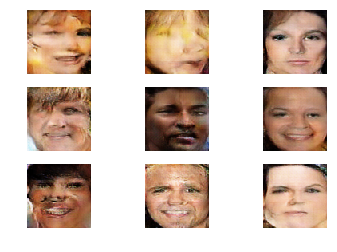

In [17]:
# load model
model = load_model('./Models/generator_model_020.h5')

# generate images
latent_points = generate_latent_points(100, 9)

# generate images
X  = model.predict(latent_points)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plot_generated(X, 3)

Oh! Wow! Can you see that! These images are generated by a neural network! Important points to observe here are; all the facial features such as eyes, nose, mouth are on correct locations. Skin tones are quite accurate. And most important part is these faces are generated by a generator with just 4 convolutional layers. Just imagine, If we could train a much larger network with all of the data available within the dataset, results could be much better. But still these results actually shows the capability of the neural networks. Well I feel this is amazing. Don't you?

# 5. Summary

Well that's it about the generative networks. We had started the journey of this concept with the discussion about generative and discriminative models, then we have build conceptual understanding about the generative adversarial networks. We had also learned about two different kind of Autoencoders to generate images. Variational autoencoder is my favorite in autoencoder. What's yours? Well then we apply learned knowledge of GANs in this project of celebrity face generation. And believe me practical application is the most interesting part about any concept.

So this is what we have learned about various generative models. I will highly encourage you guys to implement all of the networks we have learned in this concept, It will enhance your skills and understanding about the whole concept. We will meet again in some part of the world again. Till that keep learning.